In [159]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from matplotlib.gridspec import GridSpec
import sys
import os
from pathlib import Path
import torch
import gpytorch
import math
import datetime
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns


In [60]:
DEVICE = 'cuda'
FILE_PATH = '../../data/5d_rats_dataset/5D_step4.mat'


# Data setup

In [61]:
data = scipy.io.loadmat(FILE_PATH)['stim_combinations'] #scipy.io.loadmat(file_path)['Data']
resp = scipy.io.loadmat(FILE_PATH)['emg_response'] #data[0][0][0]
param = scipy.io.loadmat(FILE_PATH)['stim_combinations']# data[0][0][1]
ch2xy = param[:32,[-2,-1]].astype(int) -1
resp.shape

(8, 4, 2048, 4)

In [62]:
peak_resp = resp[:, :, :, 0]
auc_resp = resp[:, :, :, 1]
peak_norm_resp = resp[:, :, :, 2]
auc_norm_resp = resp[:, :, :, 3] 

In [63]:
def create_mean_map(resp):

    resp_mu = np.mean(resp,axis=0)
    mean_map = np.zeros((4,4,4,4,8,4))

    for e in range(resp.shape[1]):

        val_pw = np.unique(param[:,0])
        val_freq = np.unique(param[:,1])
        val_duration = np.unique(param[:,2])
        val_pos = np.unique(param[:,4])

        for i in range(len(param)):

            idx_pw = np.where(np.isclose(val_pw, param[i, 0]))[0][0]
            idx_freq = np.where(np.isclose(val_freq, param[i, 1]))[0][0]
            idx_duration = np.where(np.isclose(val_duration, param[i, 2]))[0][0]
            #idx_ch = int(np.where(np.isclose(val_ch,param[i, 4]))[0][0]-1)
            idx_ch = int(param[i, 4]-1)

            x_ch = ch2xy[idx_ch,0]
            y_ch = ch2xy[idx_ch,1]

            mean_map[e, idx_pw, idx_freq, idx_duration, x_ch, y_ch] = resp_mu[e,i]

    return mean_map

In [64]:
peak_map = create_mean_map(peak_resp)

In [65]:
peak_map.shape
#(emg channel, pulse width, frequency, stim duration, y-coord, x-coord)

(4, 4, 4, 4, 8, 4)

In [66]:
ch2xy.shape # nb channels x nb spatial dimensions

(32, 2)

In [67]:
peak_resp = torch.from_numpy(peak_resp).float().to(DEVICE)
ch2xy = param[:, [0,1,2,5,6]]
ch2xy = torch.from_numpy(ch2xy).float().to(DEVICE)



# Simple GPBO

In [68]:
class GP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(GP, self).__init__(train_x, train_y, likelihood)

        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [69]:
def optimize(model, likelihood, training_iter, train_x, train_y, verbose= True):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Includes GaussianLikelihood parameters lr= 0.01
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
      
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()

        if verbose== True:

            print('Iter %d/%d - Loss: %.3f   lengthscale_1: %.3f   lengthscale_2: %.3f   lengthscale_3: %.3f   lengthscale_4: %.3f    lengthscale_4: %.3f    kernelVar: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale[0][0].item(),
            model.covar_module.base_kernel.lengthscale[0][1].item(),
            model.covar_module.base_kernel.lengthscale[0][2].item(),
            model.covar_module.base_kernel.lengthscale[0][3].item(),
            model.covar_module.base_kernel.lengthscale[0][4].item(),
            model.covar_module.outputscale.item(),
            model.likelihood.noise.item()))

        optimizer.step()

    return model, likelihood

In [70]:
which_opt='kappa' 
this_opt=np.array([12.5])
n_subjects=4 # all 4 emgs 
n_dims=5

dim_sizes=np.array([8,4,4,4,4])
DimSearchSpace = np.prod(dim_sizes)

In [71]:
rho_low=0.1
rho_high=6.0
nrnd=5
noise_min=0.25
noise_max=10
MaxQueries =200
kappa=20
nRep=75
total_size= np.prod(dim_sizes)

In [72]:
PP = torch.zeros((n_subjects,1,len(this_opt),nRep, MaxQueries), device=DEVICE)
PP_t = torch.zeros((n_subjects,1, len(this_opt),nRep, MaxQueries), device=DEVICE)
Q = torch.zeros((n_subjects,1,len(this_opt),nRep, MaxQueries), device=DEVICE)


In [73]:
for s_idx in range(n_subjects):

    # "Ground truth" map
    MPm= torch.mean(peak_resp[:, s_idx], axis = 0)
    mMPm= torch.max(MPm)

    kappa= this_opt[0]

    # Create kernel, likelihood and priors
    # Put a  prior on the two lengthscale hyperparameters, the variance and the noise
    #The lengthscale parameter is parameterized on a log scale to constrain it to be positive
    #The outputscale parameter is parameterized on a log scale to constrain it to be positive
    priorbox= gpytorch.priors.SmoothedBoxPrior(a=math.log(rho_low),b= math.log(rho_high), sigma=0.01) 
    priorbox2= gpytorch.priors.SmoothedBoxPrior(a=math.log(0.01**2),b= math.log(100.0**2), sigma=0.01) # std
    matk= gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims= n_dims, lengthscale_prior= priorbox) 
    matk_scaled = gpytorch.kernels.ScaleKernel(matk, outputscale_prior= priorbox2)
    matk_scaled.base_kernel.lengthscale= [1.0]*n_dims
    matk_scaled.outputscale= [1.0]
    prior_lik= gpytorch.priors.SmoothedBoxPrior(a=noise_min**2,b= noise_max**2, sigma=0.01) # gaussian noise variance
    likf= gpytorch.likelihoods.GaussianLikelihood(noise_prior= prior_lik)
    likf.noise= [1.0] 

    #Initialize metrics
    perf_explore= torch.zeros((nRep, MaxQueries), device=DEVICE)
    perf_exploit= torch.zeros((nRep, MaxQueries), device=DEVICE)
    perf_rsq= torch.zeros((nRep), device=DEVICE)
    P_test =  torch.zeros((nRep, MaxQueries, 2), device=DEVICE)
    P_max_all_temp= torch.zeros((nRep, MaxQueries), device=DEVICE)

    for rep_i in range(nRep): # for each repetition

        print('rep: ' + str(rep_i))
        
        MaxSeenResp=0 
        q=0 # query number                                
        order_this= np.random.permutation(DimSearchSpace) # random permutation of each entry of the search space
        P_max=[]
        hyp=[1.0]*(n_dims+2)

        while q < MaxQueries:

            # Find next point (max of acquisition function)
            if q>=nrnd:
                
                if torch.isnan(MapPrediction).any():
                    print('nan in Mean map pred')
                    MapPrediction = torch.nan_to_num(MapPrediction)

                AcquisitionMap = MapPrediction + kappa*torch.nan_to_num(torch.sqrt(VarianceMap)) # UCB acquisition
                NextQuery= torch.where(AcquisitionMap.reshape(len(AcquisitionMap))==torch.max(AcquisitionMap.reshape(len(AcquisitionMap))))
                NextQuery = NextQuery[0][np.random.randint(len(NextQuery[0]))] if len(NextQuery[0]) > 1 else NextQuery[0][0] # Multiple maximums case
                P_test[rep_i][q][0]= NextQuery

            # Burnout queries
            else: 
                P_test[rep_i][q][0]=int(order_this[q])


            query_elec = P_test[rep_i][q][0]
            sample_resp = peak_resp[:, s_idx, int(query_elec.item())]
            test_respo = sample_resp[np.random.randint(len(sample_resp))]
            test_respo += torch.normal(0.0, 0.02*torch.mean(sample_resp).item(), size=(1,), device=DEVICE).item() # size=(1,)                   
            
            #Edge cases handling
            if test_respo < 0:
                test_respo=torch.tensor([0.0001], device= DEVICE)
            if test_respo==0 and q==0: # to avoid division by 0
                test_respo= torch.tensor([0.0001], device=DEVICE)

            
            # done reading response
            P_test[rep_i][q][1]= test_respo # The first element of P_test is the selected search space point, the second the resulting value
            y=(P_test[rep_i][:q+1,1]) 

            # updated maximum response obtained in this round
            if (torch.max(torch.abs(y)) > MaxSeenResp) or (MaxSeenResp==0):
                MaxSeenResp=torch.max(torch.abs(y))

            # search space position
            x= ch2xy[P_test[rep_i][:q+1,0].long(),:].float() 
            x = x.reshape((len(x),n_dims))

            y=y/MaxSeenResp
            y=y.float()
            
            # Initialization of the model and the constraint of the Gaussian noise 
            if q==0:
                matk_scaled.base_kernel.lengthscale= hyp[:n_dims] # Update the initial value of the parameters 
                matk_scaled.outputscale= hyp[n_dims]
                likf.noise= hyp[n_dims+1]
                m= GP(x, y, likf, matk_scaled)
                if DEVICE=='cuda':
                    m=m.cuda()
                    likf=likf.cuda()    
            # Update training data     
            else:
                m.set_train_data(x,y, strict=False)


            #Training and optimizing model
            m.train()
            likf.train()
            m, likf= optimize(m, likf, 10, x, y, verbose= False)

            #Evaluating model
            m.eval()
            likf.eval()

            with torch.no_grad():
                X_test= ch2xy  
                observed_pred = likf(m(X_test))

            VarianceMap= observed_pred.variance
            MapPrediction= observed_pred.mean

            # We only test for gp predictions at electrodes that we had queried (presumable we only want to return an electrode that we have already queried). 
            Tested= torch.unique(P_test[rep_i][:q+1,0]).long()
            MapPredictionTested=MapPrediction[Tested]

            '''
            #Before:
            if len(Tested)==1:
                BestQuery=Tested
            else:
                BestQuery= Tested[(MapPredictionTested==torch.max(MapPredictionTested)).reshape(len(MapPredictionTested))]
                if len(BestQuery) > 1:  
                    BestQuery = np.array([BestQuery[np.random.randint(len(BestQuery))].cpu()])
            '''
            
            BestQuery= Tested[(MapPredictionTested==torch.max(MapPredictionTested)).reshape(len(MapPredictionTested))]
            if len(BestQuery) > 1:  
                BestQuery = np.array([BestQuery[np.random.randint(len(BestQuery))].cpu()])

            # Maximum response at time q 
            P_max.append(BestQuery.item())
            
            hyp= torch.tensor([m.covar_module.base_kernel.lengthscale[0][0].item(),
                            m.covar_module.base_kernel.lengthscale[0][1].item(),
                            m.covar_module.base_kernel.lengthscale[0][2].item(),
                            m.covar_module.base_kernel.lengthscale[0][3].item(),
                            m.covar_module.base_kernel.lengthscale[0][4].item(),
                            m.covar_module.outputscale.item(),
                            m.likelihood.noise[0].item()], device=DEVICE)

            #hyperparams[s_i, c_i, k_i,rep_i,q,:] = hyp    0
            q+=1


        # estimate current exploration performance: knowledge of best stimulation point    
        perf_explore[rep_i,:]=MPm[P_max].reshape((len(MPm[P_max])))/mMPm
        # estimate current exploitation performance: knowledge of best stimulation point 
        perf_exploit[rep_i,:]= P_test[rep_i][:,0].long()

    PP[s_idx,0,0]=perf_explore
    Q[s_idx,0,0] = P_test[:,:,0]
    PP_t[s_idx,0,0]= MPm[perf_exploit.long().cpu()]/mMPm

rep: 0


KeyboardInterrupt: 

In [ ]:
np.savez('./output/vanilla_BO/rCer1.5/NOPRIOR_'+datetime.date.today().strftime("%y%m%d")+'_4channels_artRej_kappa20_lr001_5rnd.npz', PP=PP.cpu(), PP_t=PP_t.cpu(), Q=Q.cpu(),which_opt=which_opt, this_opt = this_opt, nrnd = nrnd, kappa = kappa)

# Proof of Concept: Separating temporal and spatial variables

## Experiment #1: Qualitative Hypothesis

I want to show that finding the best location and finding the best neurostim params are two different tasks.
Let's qualitatively track if the best responding coordinnates are consistently responding with varying stimulation parameters.


In [28]:
EMG_CHANNEL = 0
CHANNEL_19 = (3,1)


In [56]:
def visualize_heatmaps(map, ch_x_coord, ch_y_coord, channel_num):

    responses = map[EMG_CHANNEL, :, :, :, ch_y_coord, ch_x_coord]
   
    params = [[1, 0], [1, 2], [0,2]]
    axs = [2, 0, 1]
    labels=[['frequency', 'pulse width'], ['frequency', 'stim duration'], ['pulse width', 'stim duration']]

    # Create a 3x4 grid of subplots
    fig = plt.figure(figsize=(14, 10))
    gs = GridSpec(3, 5, figure=fig, width_ratios=[1, 1, 1, 1, 0.1], wspace=0.8, hspace=0.4)

    # Calculate global min and max for each row
    row_min_max = []
    for i in range(3):  # Rows
        global_min = float('inf')
        global_max = float('-inf')
        for j in range(4):  # Columns
            if i == 0:
                r = [responses[:, :, 0], responses[:, :, 1], responses[:, :, 2], responses[:, :, 3]]
            elif i == 1:
                r = [responses[0, :, :], responses[1, :, :], responses[2, :, :], responses[3, :, :]]
            elif i == 2:
                r = [responses[:, 0, :], responses[:, 1, :], responses[:, 2, :], responses[:, 3, :]]
            
            r = np.array(r)
            global_min = min(global_min, r.min())
            global_max = max(global_max, r.max())
        
        row_min_max.append((global_min, global_max))


    for i in range(3):  # Rows
        global_min, global_max = row_min_max[i]

        colorbar_ax = fig.add_subplot(gs[i, -1])  # Create the colorbar axis at the end of the row

        for j in range(4):  # Columns
            ax = fig.add_subplot(gs[i, j]) # Access the current subplot

            #r = responses[j]
            if i == 0:
                r = responses[:, :, j]
            elif i == 1:
                r = responses[j, :, :]
            elif i == 2:
                r = responses[:, j, :]
            
            #avg_response = np.mean(r, axis=axs[i])

            x = np.round(np.unique(param[:, params[i][0]]))
            y = np.round(np.unique(param[:, params[i][1]]))

            im = ax.imshow(r.T, aspect='auto', cmap='viridis', origin='lower', vmin=global_min, vmax=global_max)
            #ax.colorbar(label='Peak EMG Response')
            ax.set_xlabel(labels[i][0])
            ax.set_ylabel(labels[i][1])
            ax.set_xticks(ticks=np.arange(len(x)), labels=x)
            ax.set_yticks(ticks=np.arange(len(y)), labels=y)

        fig.colorbar(im, cax=colorbar_ax, orientation='vertical')


    # Add a single title for the whole grid
    fig.suptitle(f'Peak EMg response for {channel_num}', fontsize=16)

    # Adjust spacing between plots and title
    #fig.colorbar(im, ax=axes, orientation='vertical', label=title, shrink=0.7)

    # Show the plot
    plt.show()

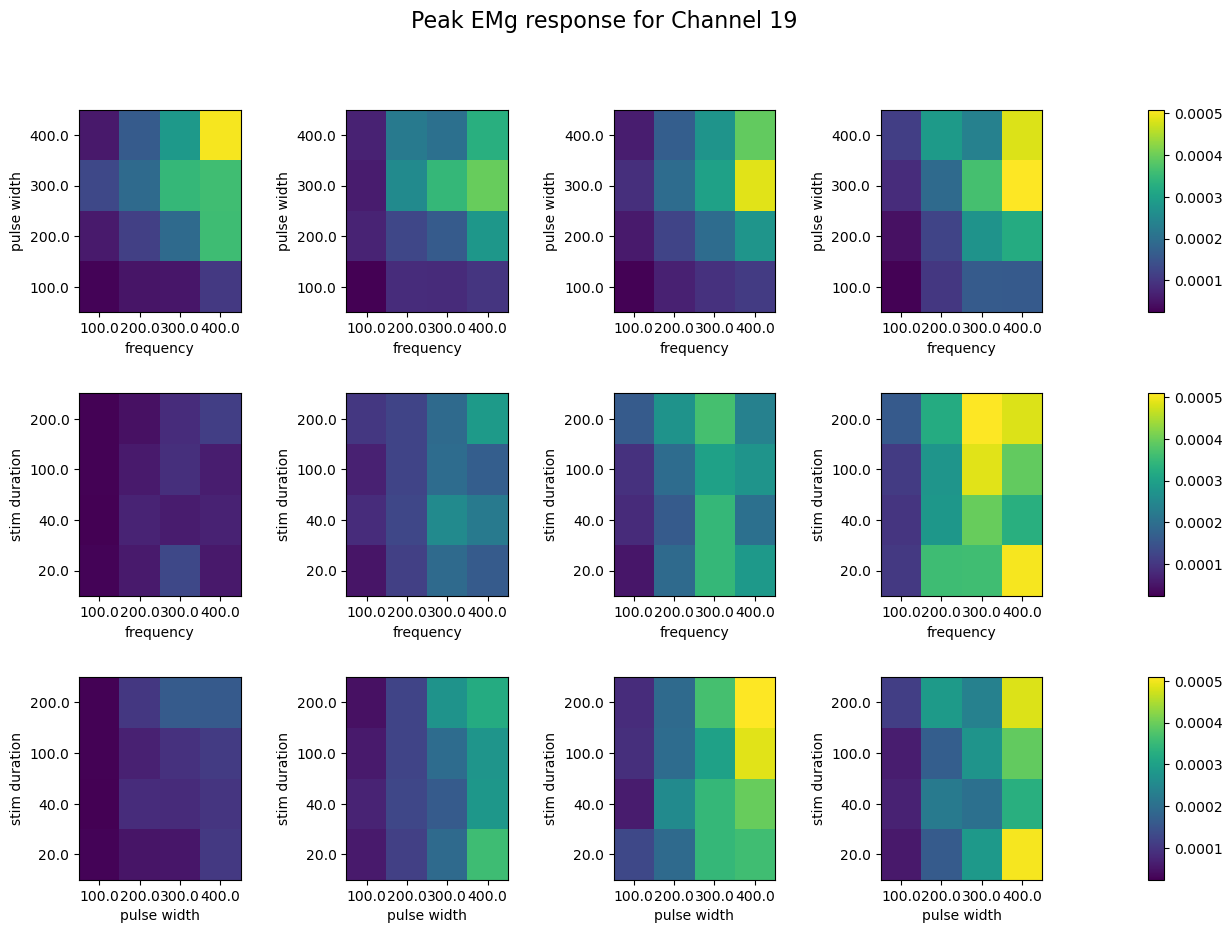

In [57]:
visualize_heatmaps(peak_map, 3, 1, 'Channel 19')

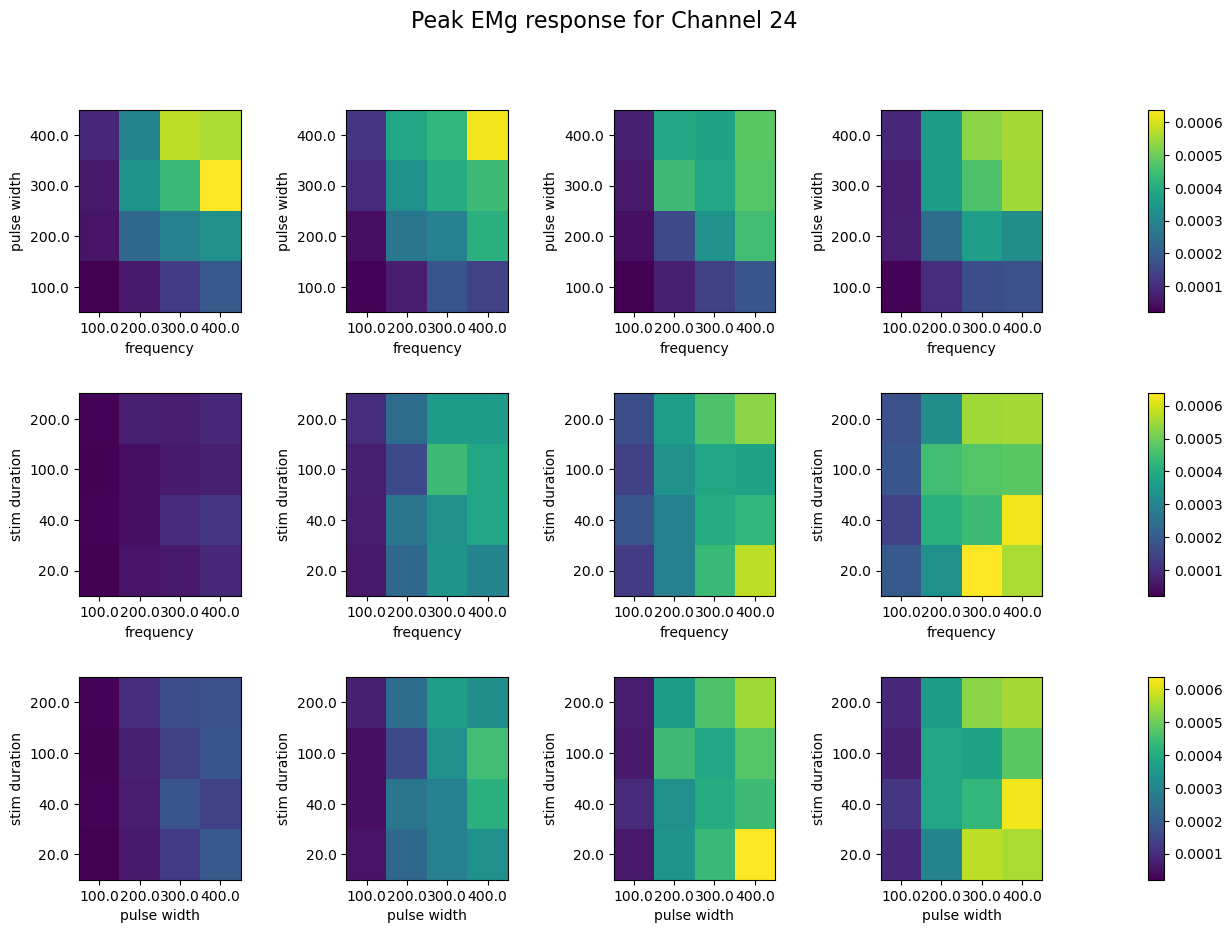

In [ ]:
visualize_heatmaps(peak_map, 3, 6, 'Channel 24')

## Experiment #2: Quantitative Validation

To check whether we can separate the temporal and spatial optimization, I will explore whether the top-K neurostim combination of params stays consistent for all coordinnates.

In [136]:
def emg_channel_consistency(map, k, verbose=False):

    emg_map = map[EMG_CHANNEL, :, :, :, :, :]

    top_k_vals = []
    top_k_coords = []

    for i in range(4):
        for j in range(8):

            resp = np.max(emg_map[:, :, :, j, i])
            top_k_vals.append(resp)
            top_k_coords.append((i, j))

            # Sort and slice to keep only the top k elements
            sorted_pairs = sorted(zip(top_k_coords, top_k_vals), key=lambda x: x[1], reverse=True)
            top_k_coords, top_k_vals = zip(*sorted_pairs)  # Unpack sorted pairs
            top_k_coords = list(top_k_coords[:k])  # Convert back to list
            top_k_vals = list(top_k_vals[:k])      # Convert back to list
            '''
            if len(top_k_vals) < k:

                top_k_vals.append(resp)
                top_k_coords.append((i, j))

                top_k_coords, top_k_vals = zip(*sorted(top_k_coords, top_k_vals))
            
            elif len(top_k_vals) >= k and resp > top_k_vals[-1]:

                top_k_vals.append(resp)
                top_k_coords.append(i, j)

                top_k_coords, top_k_vals = zip(*sorted(top_k_coords, top_k_vals))
            '''

    #print(f'best vals: {top_k_vals} and its coordinnates: {top_k_coords}')

    #Traverse combinations of neurostim params, calculate overall consistency
    consistency_score = []
    for pw in range(4):

        for freq in range(4):

            for dur in range(4):

                responses = emg_map[pw, freq, dur, :, :]
                vals = []
                coords = []
                for i in range(4):
                    for j in range(8):
                        coords.append((i, j))
                        vals.append(responses[j,i])
                
                sorted_pairs = sorted(zip(coords, vals), key=lambda x: x[1], reverse=True)
                coords, vals = zip(*sorted_pairs)
                coords = list(coords[:k])

                score = 0.0
                for coord in top_k_coords:
                    if coord in coords:
                        score += 1.0
                consistency_score.append(score / k)

    if verbose:
        print(f'Consistency score for top-{k} coordinnates: {np.mean(consistency_score)}')

    return float(np.mean(consistency_score))


In [137]:
emg_channel_consistency(peak_map, 10, verbose=False)

0.7843749999999999

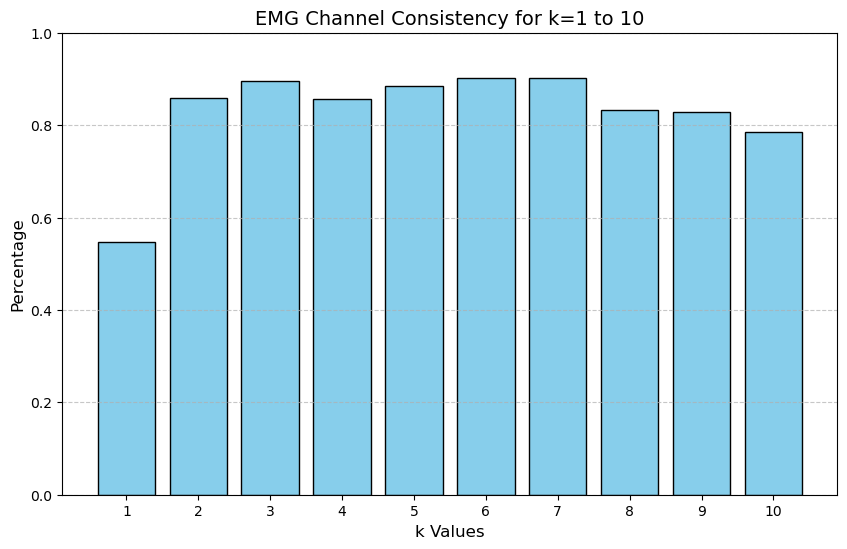

In [139]:
# Assuming peak_map is already defined
k_values = range(1, 11)  # k = 1 to 10
percentages = [emg_channel_consistency(peak_map, k) for k in k_values]

# Plot the bar plot
plt.figure(figsize=(10, 6))
plt.bar(k_values, percentages, color='skyblue', edgecolor='black')
plt.xlabel('k Values', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.title('EMG Channel Consistency for k=1 to 10', fontsize=14)
plt.xticks(k_values)  # Ensure x-ticks match k values
plt.ylim(0, 1)  # Assuming the percentage is in the range 0-100
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

# PCA analysis

In [151]:
data = peak_map[EMG_CHANNEL, :, :, :, :, :]
norm_data = (data - data.mean()) / data.std()
norm_data.shape

(4, 4, 4, 8, 4)

In [160]:
# Define the mappings for the column values
pulsewidth_values = [100.0, 200.0, 300.0, 400.0]
frequency_values = [100.0, 200.0, 300.0, 400.0]
stim_duration_values = [20.0, 40.0, 100.0, 200.0]
y_coord_values = list(range(8))
x_coord_values = list(range(4))

# Generate a meshgrid for all combinations of parameters
pulsewidth, frequency, stim_duration, y_coord, x_coord = np.meshgrid(
    pulsewidth_values, frequency_values, stim_duration_values, y_coord_values, x_coord_values, indexing="ij"
)

# Flatten each parameter grid and the data array
pulsewidth_flat = pulsewidth.ravel()
frequency_flat = frequency.ravel()
stim_duration_flat = stim_duration.ravel()
y_coord_flat = y_coord.ravel()
x_coord_flat = x_coord.ravel()
norm_data_flat = norm_data.ravel()

In [ ]:
# Create a DataFrame
df = pd.DataFrame({
    "pulsewidth": pulsewidth_flat,
    "frequency": frequency_flat,
    "stim_duration": stim_duration_flat,
    "y_coord": y_coord_flat,
    "x_coord": x_coord_flat,
    "value": norm_data_flat, 
})

# Use the 'value' column as the data for covariance
Z = df[["pulsewidth", "frequency", "stim_duration", "y_coord", "x_coord"]]

# Compute the covariance
c = Z.cov()


In [145]:
eigenvals, eigenvectors = np.linalg.eig(c)
print('Eigen values shape: ', eigenvals.shape)
print('Eigenvectors shape: ', eigenvectors)

NameError: name 'c' is not defined

# Spatial x Temporal GP

In [ ]:
class StrategicGP(gpytorch.models.ExactGP):

    def __init__(self, X_train, y_train, likelihood, d_temporal, d_spatial):
        super().__init__(X_train, y_train, likelihood)
        
        # Temporal: Univariate kernels for efficient computation
        self.temporal_kernels = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=1), batch_shape=torch.Size([d_temporal])
        )
        
        # Spatial: Multivariate kernel
        self.spatial_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=d_spatial)
        )
        
        # Mean module
        self.mean_module = gpytorch.means.ConstantMean()

    def forward(self, X):
        mean = self.mean_module(X)
        
        # Split X into temporal and spatial components
        X_temporal = X[:, :3].mT.unsqueeze(-1)  # Temporal: d_temporal x n x 1
        X_spatial = X[:, 3:]  # Spatial: n x d_spatial

        # Temporal: Sum of univariate RBF kernels
        temporal_covars = self.temporal_kernels(X_temporal)  # Shape: d_temporal x n x n
        temporal_covar = temporal_covars.sum(dim=0)  # Aggregate additively: n x n

        # Spatial: Multivariate RBF kernel
        spatial_covar = self.spatial_kernel(X_spatial)  # Shape: n x n

        # Combine temporal and spatial covariances
        covar = temporal_covar + spatial_covar

        return gpytorch.distributions.MultivariateNormal(mean, covar)
